<h2>Introduction</h2>

Step-pool sequences are morphologic features of steep streams forming from the interaction of a flowing fluid over an erobible boundary. The following equations are primarily derived from conservation of fluid momentum and conservation of sediment mass. Introducing the Law of the Wall as a closure condition, the system of partial differential equations describes step formation. 

<h2>Model Equations</h2>

$$\begin{equation}
    \zeta (u^*\frac{\partial u^*}{\partial x^*}) = -\zeta \frac{\partial }{\partial x^*}\frac{1}{u^*} - \frac{\partial \eta^*}{\partial x^*} - \beta {u^*}^3 \frac{\left(1 - 2\frac{1}{\zeta}u^*r^* + \frac{1}{\zeta^2}{u^*}^2{r^*}^2\right)}{\left(\ln{\left(\zeta\frac{1}{e}\frac{1}{{u^{*}}r^{*}}\right)} + \frac{1}{\zeta}r^* u^{*}\right)^{2}} - \frac{C_D{*}}{2}\eta^* {u^{*}}^3 + \psi \tan{\theta}
\end{equation}$$

$$\begin{equation} 
\alpha \frac{\partial \eta^*}{\partial t^*} =
    \begin{cases} 
0 & \text{if } {\tau_b}^* < \tau_{cr}^*, \\
-\frac{\partial }{\partial x^*}\left[\alpha \frac{{u^{*}}^2 \left(1 - 2\frac{1}{\zeta}u^*r^{*} + \frac{1}{\zeta^2}{u^{*}}^2{r^{*}}^2\right)}{\left(\ln{\left(\zeta\frac{1}{e}\frac{1}{{u^{*}}r^{*}}\right)} + \frac{1}{\zeta}u^*r^{*}\right)^{2}} - {\tau_{cr}}^*\right] & \text{if } {\tau_b}^* \geq \tau_{cr}^*.
\end{cases}
\end{equation}$$

$$ \begin{equation}
    {\tau_b}^* = \alpha \frac{{u^{*}}^2 \left(1 - 2\frac{1}{\zeta}u^*r^{*} + \frac{1}{\zeta^2}{u^{*}}^2{r^{*}}^2\right)}{\left(\ln{\left(\zeta\frac{1}{e}\frac{1}{{u^{*}}r^{*}}\right)} + \frac{1}{\zeta}u^*r^{*}\right)^{2}}
\end{equation} $$

$$ \begin{equation}
    D(x^*) = \frac{2r_0 - D_{min}}{2} \cos{(2\pi x^*)} + \frac{2r_0 + D_{min}}{2}
\end{equation}$$

$$ C_D(\eta^* - \eta_{min}^*) = 1.79 e^{-0.77\frac{r_0}{\lambda}(\eta^* - \eta_{min}^*)}$$

$$\begin{equation}
    \frac{r(x^*)}{r_0} = (1 - \frac{D}{r_0})cos{2\pi x^*} + (1 + \frac{D}{r_0})
\end{equation}$$

$$\alpha = \frac{\rho_f (gq_w)^\frac{2}{3} \kappa^2}{(\rho_s - \rho_f)gD}$$

$$\zeta = \frac{q_w^{\frac{2}{3}}}{g^\frac{1}{3}r_0}$$

$$\beta = \frac{\lambda \kappa^2}{r_0}$$

$$\psi = \frac{\lambda}{r_0}$$

In [1]:
using Printf

# Function to convert a number to scientific notation with 10^power format
function scientific_notation(value)
    if value == 0
        return "0"
    else
        exponent = floor(log10(abs(value)))
        coefficient = value / (10.0^exponent)
        return @sprintf("\$ %.2f \\times 10^{%d} \$", coefficient, Int(exponent))
    end
end

scientific_notation (generic function with 1 method)

In [2]:
# Constants
τ_cr = 0.05 # Critical Shields Number
g = 9.81 # Gravitational Acceleration m/s^2
κ = 0.41 # Von Karman constant
q_w = 10 # Discharge per width
A = 0.5 # Roughness Amplitude
r_0 = 0.5 # Immobile Clast Radius
D_min = 0.25 # Mobile Layer Grain Size
λ = 30 # Roughness patch spacing
k = (2*pi)/λ # Wavenumber
ρ_s = 2650 # Sediment density
ρ = 1000 # Fluid density
θ = 0.04996 # 5% Angle of slope in radians (7% 0.06989)
γ = 1;

In [3]:
# Dimensionless Parameters
ζ = (q_w^(2.0/3.0))/((g^(1.0/3.0))*r_0)
β = (λ*κ^2.0)/(r_0)
ψ = λ / r_0;

In [4]:
using ModelingToolkit, DomainSets, DifferentialEquations

@parameters x, t
@variables u(..) [bounds=(0,Inf)]
@variables η(..) 

# Linear Operators
Dx = Differential(x)
Dt = Differential(t)

# Periodic Roughness
r = (1-(D_min/r_0))*cos(2.0*pi*x) + (1+(D_min/r_0))

# Grain Size Wave
D = ((2.0*r_0 - D_min)/2.0) * cos(2.0 * pi * x) + ((2.0*r_0 + D_min)/2.0)

# Varying Dimensionless Parameter
α = (ρ*(g*q_w)^(2.0/3.0) * κ^2.0) / ((ρ_s - ρ)*g*D)

# Drag Coefficient
C_D = 1.79*exp(-0.77*(r_0/(λ/2.0))*(η(x,t) - minimum(η(x,t))))

# Term inside the Logarithm
log_term = (log(ζ / (exp(1)*u(x, t) * r)))

# Equation (9)
eq1 = ζ * u(x,t) * Dx(u(x,t)) ~ -ζ * expand_derivatives(Dx(1/u(x,t))) - Dx(η(x,t)) - β*u(x,t)^3.0 * (1.0 - ((2/ζ) * u(x,t) * r) + ((1/ζ^(2.0)) * u(x,t)^(2.0) * r^(2.0))) * ((log_term + ((1/ζ) * u(x,t) * r))^(-2.0)) - (C_D/2.0)*(η(x,t)*u(x,t)^3.0) + ψ*tan(θ)

# Equation (10)
log_dx = Dx((α * u(x,t)^2.0) * (1 - ((2/ζ) * u(x,t) * r) + ((1/ζ^(2.0)) * u(x,t)^(2.0) * r^(2.0))) * (log_term + ((1/ζ) * u(x,t) * r))^(-2.0) - τ_cr)
eq2B = -expand_derivatives(log_dx^γ) * (1/α)
τ = ((α*u(x,t)^2.0) * (1 - ((2/ζ) * u(x,t) * r) + ((1/ζ^(2.0)) * u(x,t)^(2.0) * r^(2.0))) * (log_term + (u(x,t)*r / ζ))^(-2.0))
f(x,t) = ((τ >= τ_cr) * eq2B)
eq2 = Dt(η(x,t)) ~ f(x,t)

# Combine into a system
eq = [eq1, eq2]

# Domain
x_start = t_start = 0.0
x_end = 2
t_end = 10.0

domains = [x ∈ IntervalDomain(x_start,x_end), t ∈ IntervalDomain(t_start,t_end)]

# Periodic Boundary Conditions
η0(x, t) = 0.0
u0(x, t) = 2.0

bcs = [η(x, 0.0) ~ η0(x, 0.0),
        η(x_start, t) ~ η(x_end, t),
        u(x_start,t) ~ u(x_end,t),
        u(x,0.0) ~ u0(x,0.0)]

@named pdesys = PDESystem(eq, bcs, domains, [x, t], [u(x, t), η(x, t)])

PDESystem
Equations: Equation[4.336509743640087u(x, t)*Differential(x)(u(x, t)) ~ 3.0000964973328834 + (-10.085999999999999(1.0 - 0.46120039345770975(1.5 + 0.5cos(6.283185307179586x))*u(x, t) + 0.05317645073138657((1.5 + 0.5cos(6.283185307179586x))^2.0)*(u(x, t)^2.0))*(u(x, t)^3.0)) / ((log(4.336509743640087 / (2.718281828459045(1.5 + 0.5cos(6.283185307179586x))*u(x, t))) + 0.23060019672885487(1.5 + 0.5cos(6.283185307179586x))*u(x, t))^2.0) - Differential(x)(η(x, t)) + 4.336509743640087(1 / (u(x, t)^2))*Differential(x)(u(x, t)) - 0.895η(x, t)*(u(x, t)^3.0), Differential(t)(η(x, t)) ~ (16186.5(((3575.5845471784314(1 - 0.46120039345770975(1.5 + 0.5cos(6.283185307179586x))*u(x, t) + 0.05317645073138657((1.5 + 0.5cos(6.283185307179586x))^2.0)*(u(x, t)^2.0))*(u(x, t)^2.0)) / (16186.5(0.625 + 0.375cos(6.283185307179586x))*((log(4.336509743640087 / (2.718281828459045(1.5 + 0.5cos(6.283185307179586x))*u(x, t))) + 0.23060019672885487(1.5 + 0.5cos(6.283185307179586x))*u(x, t))^2.0))) >= 0.05)*(0

In [5]:
using MethodOfLines
# Finite Difference Method
discretization = MOLFiniteDifference([x => 100], t);

In [6]:
# Define the differential equations problem
prob = discretize(pdesys, discretization);

┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines C:\Users\cmeri\.julia\packages\MethodOfLines\xyn4D\src\system_parsing\pde_system_transformation.jl:43


In [7]:
# Solve PDE system
sol1 = solve(prob, Rosenbrock23(), saveat = 0.001, maxiters=1e5);

In [8]:
disct = sol1[t]
discx = sol1[x]
discu = sol1[u(x,t)]
discη = sol1[η(x,t)];

<h2>Summary Plots</h2>

<h3>Bed Surface</h3>

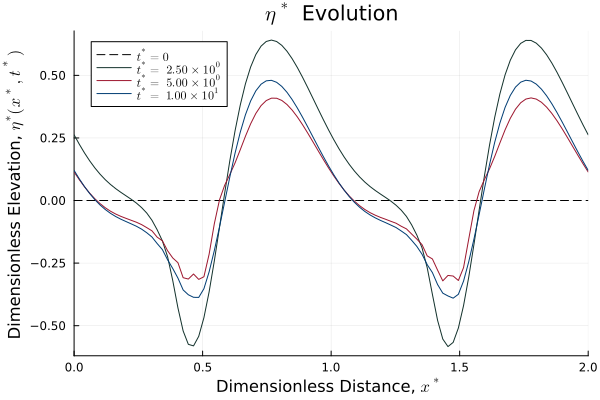

In [9]:
using Plots, LaTeXStrings

# Initial Bed surface
plot(discx, discη[:,1], xlim=(0,2), title=latexstring("\$η^*\$ Evolution"), 
              color="#000000", xlabel=latexstring("Dimensionless Distance, \$x^*\$"), ylabel=latexstring("Dimensionless Elevation, \$η^{*}(x^*,t^*)\$"),
        label=latexstring("\$t^{*} = 0\$"), linestyle=:dash, legend=:topleft)

plot!(discx,discη[:,2501],label=latexstring("\$t^{*} = \$ $(scientific_notation(disct[2501]))"), color="#12312b")

plot!(discx,discη[:,5001],label=latexstring("\$t^{*} = \$ $(scientific_notation(disct[5001]))"), color="#9d162e")

p=plot!(discx,discη[:,10001],label=latexstring("\$t^{*} = \$ $(scientific_notation(disct[10001]))"), color="#003c73")

<h3>Velocity</h3>

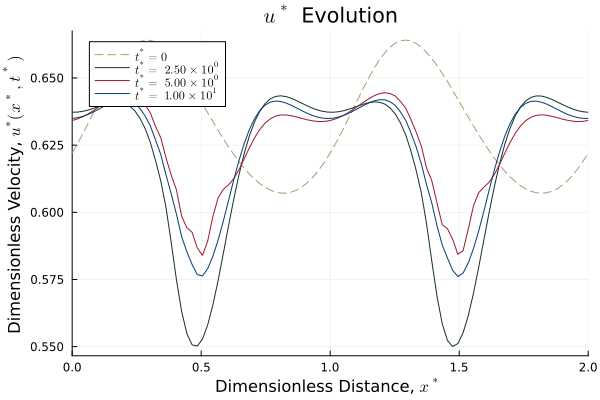

In [10]:
# Initial Velocity
plot(discx, discu[:,1], xlim=(0,2), title=latexstring("\$u^*\$ Evolution"), 
              color="#a49f6d", xlabel=latexstring("Dimensionless Distance, \$x^*\$"), ylabel=latexstring("Dimensionless Velocity, \$u^{*}(x^*,t^*)\$"),
        label=latexstring("\$t^{*} = 0\$"), linestyle=:dash, legend=:topleft)

plot!(discx,discu[:,2501],label=latexstring("\$t^{*} = \$ $(scientific_notation(disct[2501]))"), color="#12312b")

plot!(discx,discu[:,5001],label=latexstring("\$t^{*} = \$ $(scientific_notation(disct[5001]))"), color="#9d162e")

plot!(discx,discu[:,10001],label=latexstring("\$t^{*} = \$ $(scientific_notation(disct[10001]))"), color="#003c73")